In [1]:
library(tidyverse)
library(cowplot)
library(gridExtra)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.2.0     ✔ purrr   0.3.2
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   0.8.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave


Attaching package: ‘gridExtra’

The following object is masked from ‘package:dplyr’:

    combine



In [2]:
`%+replace%` <- ggplot2::`%+replace%`

theme_zietzm <- function(base_size = 11.5, base_family = "") {
    # Starts with theme_bw and then modify some parts
    # Theme options are documentated at http://docs.ggplot2.org/current/theme.html
    ggplot2::theme_classic(base_size = base_size, base_family = base_family) %+replace%
    ggplot2::theme(

        strip.background  = ggplot2::element_rect(fill = NA, colour = 'grey90', size = 0),
        strip.text = element_text(vjust = 1, size = 10),
        plot.margin       = ggplot2::margin(t=2, r=2, b=2, l=2, unit='pt'),
        legend.spacing     = grid::unit(0.1, 'cm'),
        legend.key        = ggplot2::element_blank(),
        panel.border=element_rect(fill = NA, color = 'black', size = 0.5), 
        axis.line=element_line(size=0),
    )
}

In [3]:
ppi_df <- read_tsv('../../data/task3/3.all_nodes/ppi.tsv.xz') 

ppi_degree_df <- ppi_df %>%
    select(-starts_with('name')) %>%
    gather('id_side', 'id', id_a:id_b) %>%
    group_by(.dots=c("id")) %>%
    summarize_at(vars(train, test_new), funs(sum)) %>%
    rename(biased=train, unbiased=test_new)

ppi_vis_dists <- ppi_degree_df %>%
    gather('network_type', 'degree', biased:unbiased) %>%
    mutate(name = 'ppi')

head(ppi_vis_dists, 2)

Parsed with column specification:
cols(
  name_a = col_character(),
  name_b = col_character(),
  id_a = col_double(),
  id_b = col_double(),
  train = col_double(),
  test_recon = col_double(),
  test_new = col_double()
)
Warning message:
“funs() is soft deprecated as of dplyr 0.8.0
Please use a list of either functions or lambdas: 

  # Simple named list: 
  list(mean = mean, median = median)

  # Auto named with `tibble::lst()`: 
  tibble::lst(mean, median)

  # Using lambdas
  list(~ mean(., trim = .2), ~ median(., na.rm = TRUE))
This warning is displayed once per session.”

id,network_type,degree,name
<dbl>,<chr>,<dbl>,<chr>
0,biased,55,ppi
1,biased,3,ppi


In [4]:
tftg_df <- read_tsv('../../data/task3/3.all_nodes/tftg.tsv.xz')

tftg_degree_df <- tftg_df %>%
    select(-starts_with('name')) %>%
    gather('id_side', 'id', id_a:id_b) %>%
    group_by(.dots=c("id_side", "id")) %>%
    summarize_at(vars(train, test_new), funs(sum)) %>%
    rename(biased=train, unbiased=test_new)

tftg_vis_dists <- tftg_degree_df %>%
    gather('network_type', 'degree', biased:unbiased) %>%
    mutate(name = id_side %>% recode(id_a = 'tftg_source', id_b = 'tftg_target')) %>%
    ungroup() %>%
    select(-id_side)

head(tftg_vis_dists, 2)

Parsed with column specification:
cols(
  name_a = col_character(),
  name_b = col_character(),
  id_a = col_double(),
  id_b = col_double(),
  train = col_double(),
  test_recon = col_double(),
  test_new = col_double()
)


id,network_type,degree,name
<dbl>,<chr>,<dbl>,<chr>
0,biased,13,tftg_source
1,biased,67,tftg_source


In [5]:
biorxiv_df <- read_tsv('../../data/task3/3.all_nodes/biorxiv.tsv.xz')

biorxiv_degree_df <- biorxiv_df %>%
    select(-starts_with('name')) %>%
    gather('id_side', 'id', id_a:id_b) %>%
    group_by(.dots=c("id")) %>%
    summarize_at(vars(train, test_new), funs(sum)) %>%
    rename(biased=train, unbiased=test_new)

biorxiv_vis_dists <- biorxiv_degree_df %>%
    gather('network_type', 'degree', biased:unbiased) %>%
    mutate(
        name = 'co_author',
        network_type = network_type %>% recode(biased = "<2018", unbiased = ">=2018")
    )

head(biorxiv_vis_dists, 2)

Parsed with column specification:
cols(
  name_a = col_character(),
  name_b = col_character(),
  id_a = col_double(),
  id_b = col_double(),
  train = col_double(),
  test_recon = col_double(),
  test_new = col_double()
)


id,network_type,degree,name
<dbl>,<chr>,<dbl>,<chr>
0,<2018,12,co_author
2,<2018,8,co_author


In [6]:
vis_df <- bind_rows(ppi_vis_dists, tftg_vis_dists, biorxiv_vis_dists) %>%
    mutate(
        name = name %>% recode_factor(
            ppi = 'PPI', 
            tftg_source = 'TF-TG: TF', 
            tftg_target = 'TF-TG: TG',
            co_author = 'Co-authorship',
        ),
        network_type = network_type %>% recode_factor(
            biased = 'Literature-derived',
            unbiased = 'Systematic',
        )
    )

head(vis_df, 2)

id,network_type,degree,name
<dbl>,<fct>,<dbl>,<fct>
0,Literature-derived,55,PPI
1,Literature-derived,3,PPI


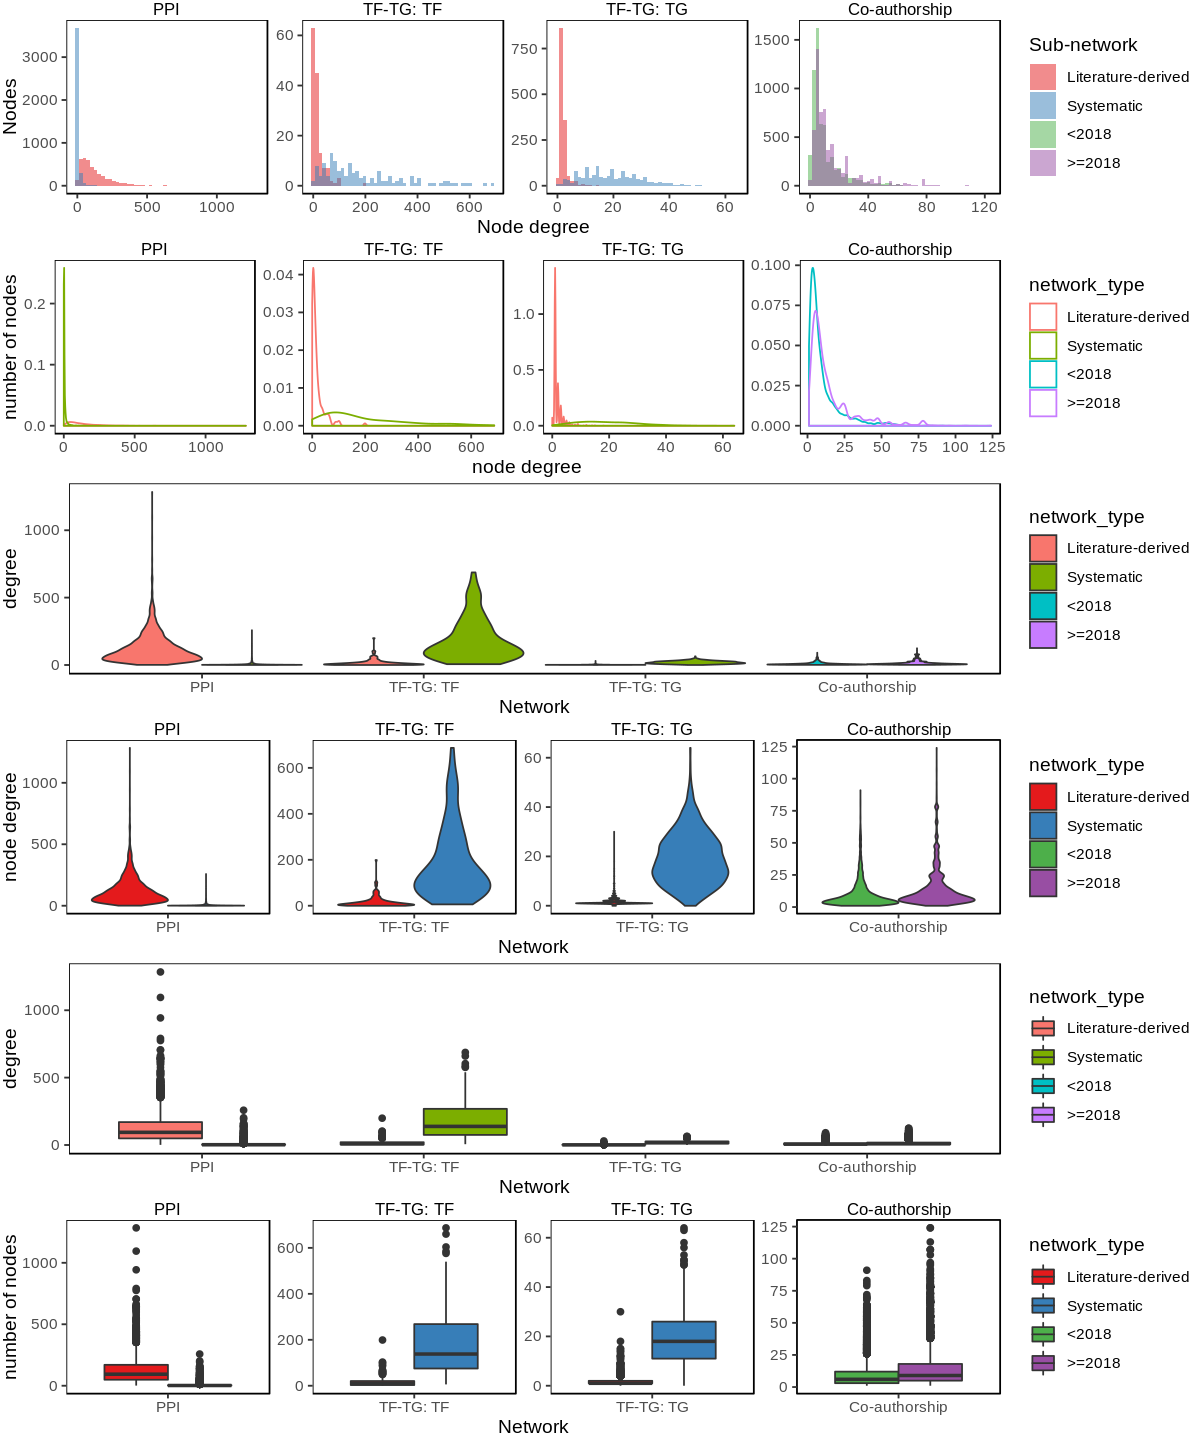

In [7]:
options(repr.plot.width=10, repr.plot.height=12)

histogram_dists <- (
    ggplot(vis_df, aes(x = degree, fill=network_type))
    + geom_histogram(position = position_identity(), alpha = 0.5, bins = 50)
    + facet_wrap("name", scales='free', nrow=1)
    + scale_fill_brewer(palette = "Set1")
    + ylab('Nodes')
    + xlab('Node degree')
    + theme_zietzm()
    + labs(fill='Sub-network')
)

kde_dists <- (
    ggplot(vis_df, aes(x = degree, color=network_type))
    + geom_density(position = position_identity(), alpha = 0.5)
    + facet_wrap("name", scales='free', nrow=1)
    + scale_fill_brewer(palette = "Set1")
    + ylab('number of nodes')
    + xlab('node degree')
    + theme_zietzm()
)

violin <- (
    ggplot(vis_df, aes(x = name, y = degree, fill = network_type))
    + geom_violin(scale = 'width')
    + xlab('Network')
    + theme_zietzm()
)

violin_facet <- (
    ggplot(vis_df, aes(x = name, y = degree, fill = network_type))
    + geom_violin(scale = 'width')
    + facet_wrap("name", scales='free', nrow=1)
    + scale_fill_brewer(palette = "Set1")
    + ylab('node degree')
    + xlab('Network')
    + theme_zietzm()
)

box <- (
    ggplot(vis_df, aes(x = name, y = degree, fill = network_type))
    + geom_boxplot(position = 'dodge')
    + xlab('Network')
    + theme_zietzm()
)

box_facet <- (
    ggplot(vis_df, aes(x = name, y = degree, fill = network_type))
    + geom_boxplot(position = 'dodge')
    + facet_wrap("name", scales='free', nrow=1)
    + scale_fill_brewer(palette = "Set1")
    + ylab('number of nodes')
    + xlab('Network')
    + theme_zietzm()
)

grid.arrange(histogram_dists, kde_dists, violin, violin_facet, box, box_facet, ncol = 1)

## Well-studied bias

In [8]:
ppi_df <- read_tsv('../../data/task3/2.edges//ppi.tsv.xz')
tftg_df <- read_tsv('../../data/task3/2.edges//tftg.tsv.xz')

head(ppi_df, 2)

Parsed with column specification:
cols(
  name_a = col_character(),
  name_b = col_character(),
  id_a = col_double(),
  id_b = col_double(),
  train = col_double(),
  test_recon = col_double(),
  test_new = col_double()
)
Parsed with column specification:
cols(
  name_a = col_character(),
  name_b = col_character(),
  id_a = col_double(),
  id_b = col_double(),
  train = col_double(),
  test_recon = col_double(),
  test_new = col_double()
)


name_a,name_b,id_a,id_b,train,test_recon,test_new
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
A0A087WT00,O00154,0,48,1,1,0
A0A087WT00,O43736,0,237,0,1,0


In [9]:
format_degrees <- function(df) {
    df %>%
        group_by(id_a) %>%
        summarise(
            degree_a_train = sum(train),
            degree_a_test_recon = sum(test_recon),
            degree_a_test_new = sum(test_new)
        ) %>%
        full_join(
            df %>%
            group_by(id_b) %>%
            summarise(
                degree_b_train = sum(train),
                degree_b_test_recon = sum(test_recon),
                degree_b_test_new = sum(test_new)
            ),
            by = c("id_a" = "id_b")
        ) %>%
        replace(is.na(.), 0) %>%
        mutate(
            degree_train = degree_a_train + degree_b_train,
            degree_test_recon = degree_a_test_recon + degree_b_test_recon,
            degree_test_new = degree_a_test_new + degree_b_test_new
        ) %>%
        select(degree_train, degree_test_recon, degree_test_new)
}

In [10]:
ppi_degrees_df <- format_degrees(ppi_df)
tftg_degrees_df <- format_degrees(tftg_df)

df <- bind_rows(
    ppi_degrees_df %>% mutate(network = 'PPI'),
    tftg_degrees_df %>% mutate(network = 'TF-TG')
)

reconstruction_df <- df %>%
    rename(x = degree_test_recon, y = degree_train) %>%
    select(x, y, network) %>%
    mutate(task = 'Reconstruction')
    

systematic_df <- df %>%
    rename(x = degree_test_new, y = degree_test_recon) %>%
    select(x, y, network) %>%
    mutate(task = 'Systematic')

vis_df <- bind_rows(reconstruction_df, systematic_df)

head(vis_df, 2)

x,y,network,task
<dbl>,<dbl>,<chr>,<chr>
75,55,PPI,Reconstruction
3,3,PPI,Reconstruction


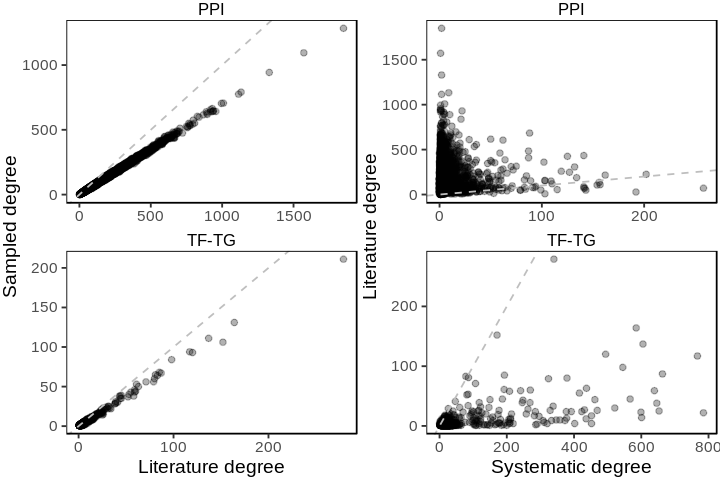

In [11]:
options(repr.plot.width=6, repr.plot.height=4)

reconstruction <- (
    ggplot(vis_df %>% filter(task == 'Reconstruction'), aes(x = x, y = y))
    + geom_point(alpha = 0.3)
    + geom_abline(slope = 1, intercept = 0, color = 'grey', linetype = 'dashed')
    + xlab('Literature degree')
    + ylab('Sampled degree')
    + facet_wrap('network', ncol = 1, scales = 'free')
    + theme_zietzm()
)

systematic <- (
    ggplot(vis_df %>% filter(task == 'Systematic'), aes(x = x, y = y))
    + geom_point(alpha = 0.3)
    + geom_abline(slope = 1, intercept = 0, color = 'grey', linetype = 'dashed')
    + xlab('Systematic degree')
    + ylab('Literature degree')
    + facet_wrap('network', ncol = 1, scales = 'free')
    + theme_zietzm()
)

g <- grid.arrange(reconstruction, systematic, ncol = 2)

Warning message:
“Transformation introduced infinite values in continuous x-axis”Warning message:
“Transformation introduced infinite values in continuous x-axis”

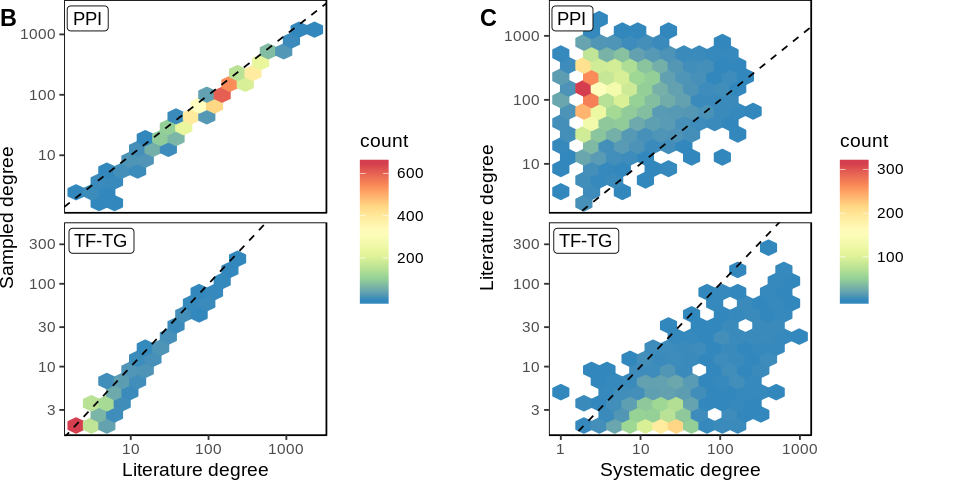

In [12]:
palette <- 'Spectral'
direction <- -1

options(repr.plot.width=8, repr.plot.height=4)

label_df <- vis_df %>% 
    filter(task == 'Reconstruction') %>%
    group_by(network) %>%
    summarize(y = max(y), label = first(network))

reconstruction <- (
    ggplot(vis_df %>% filter(task == 'Reconstruction'), aes(x = x + 1, y = y + 1))
#     + geom_point(size = 0.5, alpha = 0.2)
    + stat_binhex(aes(color = ..count..), bins = 15)
    + geom_abline(slope = 1, intercept = 0, color = 'black', linetype = 'dashed')
    + geom_label(data = label_df, aes(label = label, x = 0, y = 2 * y, hjust = -0.075, vjust = 0.85))
    + xlab('Literature degree')
    + ylab('Sampled degree')
    + facet_grid(rows = vars(network), scales = 'free')
    + scale_x_log10()
    + scale_y_log10()
    + theme_zietzm()
    + scale_fill_distiller(palette = palette, direction = direction)
    + scale_color_distiller(palette = palette, direction = direction)
    + theme(plot.margin = unit(c(0, 1, 0, 0), "cm"))
#     + theme(strip.text = element_text(hjust = 0))
    + theme(strip.placement = "outside", strip.text = element_blank())
)

systematic <- (
    ggplot(vis_df %>% filter(task == 'Systematic'), aes(x = x + 1, y = y + 1))
    + stat_binhex(aes(color = ..count..), bins = 15)
#     + geom_point(size = 0.5, alpha = 0.2)
    + geom_abline(slope = 1, intercept = 0, color = 'black', linetype = 'dashed')
    + geom_label(data = label_df, aes(label = label, x = 0, y = 2 * y, hjust = -0.075, vjust = 0.85))
#     + stat_density2d()
    + xlab('Systematic degree')
    + ylab('Literature degree')
    + facet_grid(rows = vars(network), scales = 'free', switch = 'y')
    + scale_x_log10()
    + scale_y_log10()
    + theme_zietzm()
    + scale_fill_distiller(palette = palette, direction = direction)
    + scale_color_distiller(palette = palette, direction = direction)
    + theme(plot.margin = unit(c(0, 1, 0, 0), "cm"))
    + theme(strip.placement = "outside", strip.text = element_blank())
)

degree_bias <- plot_grid(reconstruction, systematic, ncol = 2, labels = c("B", "C"), hjust = -0.01)

degree_bias

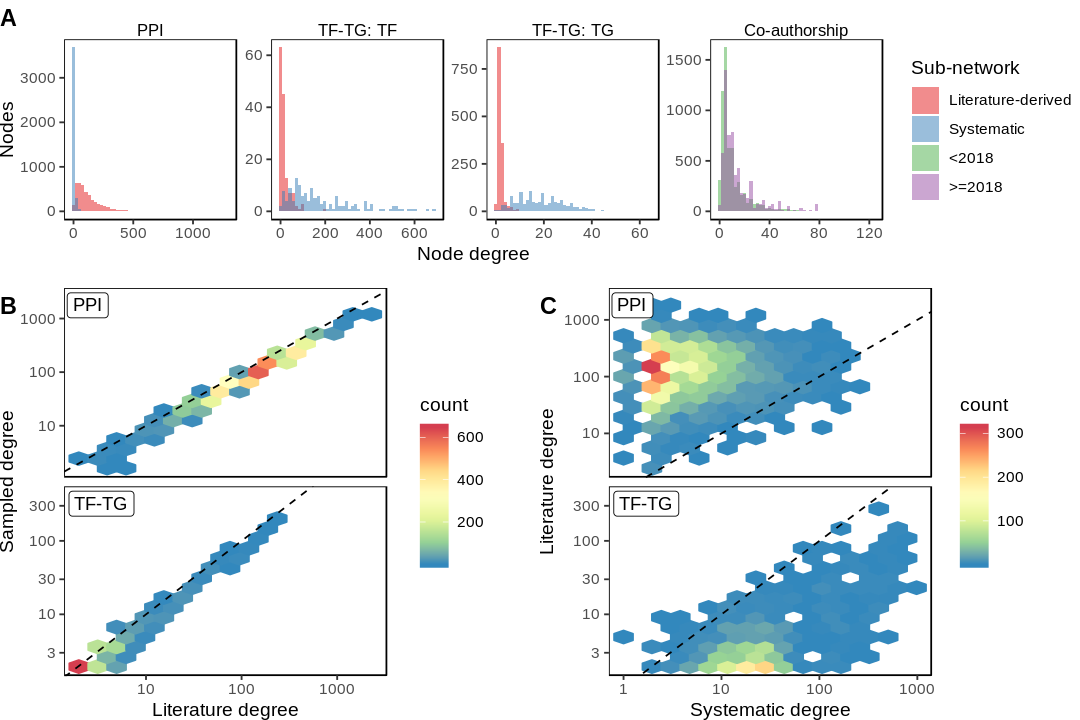

In [13]:
options(repr.plot.width=9, repr.plot.height=6)

fig1 <- plot_grid(histogram_dists + theme(plot.margin = unit(c(0.5, 0, 0.5, 0), "cm")), 
                  degree_bias, ncol = 1, rel_heights = c(1, 1.5), 
                  labels = c("A", ""), hjust = -0.01)

ggsave(plot = fig1, filename = '../../img/fig1.degree_bias.png', width = 9, 
          height = 6, dpi = 500)

fig1